In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Layer, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Embedding, Input,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# **KONFIGURASI ViT**

In [ ]:
# Path Dataset
PATH_SOURCE = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/training'
PATH_TEST_FINAL = '/content/drive/MyDrive/Machine Learning/Dataset Sampah/validation'

# Parameter Gambar
UKURAN_GAMBAR = (128, 128)
BATCH_SIZE = 32

# Parameter Arsitektur ViT
PATCH_SIZE = 16
NUM_PATCHES = (UKURAN_GAMBAR[0] // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 4
MLP_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
MLP_DROPOUT = 0.1

print(f"Konfigurasi ViT: Input {UKURAN_GAMBAR}, Patch {PATCH_SIZE}x{PATCH_SIZE}, {TRANSFORMER_LAYERS} Layers")


Konfigurasi ViT: Input (128, 128), Patch 16x16, 4 Layers


# **DEFINISI LAPISAN KUSTOM ViT**

In [ ]:
class Patches(Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def create_mini_vit():
    inputs = Input(shape=(UKURAN_GAMBAR[0], UKURAN_GAMBAR[1], 3))

    # Patch Creation
    patches = Patches(PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # Transformer Blocks
    for _ in range(TRANSFORMER_LAYERS):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=MLP_DROPOUT
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])

        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=MLP_DROPOUT)
        encoded_patches = Add()([x3, x2])

    # Output Head
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = GlobalAveragePooling1D()(representation)

    # Classifier
    features = Dense(256, activation='relu')(representation)
    features = Dropout(0.5)(features)
    logits = Dense(JUMLAH_KELAS, activation='softmax')(features)

    return Model(inputs=inputs, outputs=logits)

# **DATA GENERATOR**

In [ ]:
# A. Setup Augmentasi Training + Split Validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# B. Setup Test (Tanpa Augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Menyiapkan Data Generator ---")

# 1. TRAINING Generator (80% dari folder Training)
train_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# 2. VALIDATION Generator
validation_generator = train_datagen.flow_from_directory(
    PATH_SOURCE,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 3. TEST Generator (Folder Validation Lama)
test_generator = test_datagen.flow_from_directory(
    PATH_TEST_FINAL,
    target_size=UKURAN_GAMBAR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ambil Label
LABEL_KELAS = list(train_generator.class_indices.keys())
JUMLAH_KELAS = len(LABEL_KELAS)
print(f"Kelas: {LABEL_KELAS}")


--- Menyiapkan Data Generator ---
Found 1841 images belonging to 3 classes.
Found 459 images belonging to 3 classes.
Found 813 images belonging to 3 classes.
Kelas: ['Kaca', 'Kardus', 'Plastik']


# **BUILD MODEL**

In [ ]:
model = create_mini_vit()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 768) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 64, 64)    │     53,312 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64, 128)   │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64, 64)    │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64, 64)    │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 64, 64)    │          0 │ dropout_15[0][0], │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 128)   │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 403,651 (1.54 MB)

 Trainable params: 403,651 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

# **Training Model**


Model akan disimpan ke: /content/drive/MyDrive/Machine Learning/Models/vit_mini_waste_classifier_3split.keras

Mulai Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3818 - loss: 1.1703 
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to /content/drive/MyDrive/Machine Learning/Models/vit_mini_waste_classifier_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 842s 14s/step - accuracy: 0.3820 - loss: 1.1695 - val_accuracy: 0.4062 - val_loss: 1.0545
Epoch 2/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5625 - loss: 0.8979

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.40625
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5625 - loss: 0.8979 - val_accuracy: 0.4040 - val_loss: 1.0555
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4458 - loss: 1.0730
Epoch 3: val_accuracy improved from 0.40625 to 0.40848, saving model to /content/drive/MyDrive/Machine Learning/Models/vit_mini_waste_classifier_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.4458 - loss: 1.0729 - val_accuracy: 0.4085 - val_loss: 1.0366
Epoch 4/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4062 - loss: 1.0884
Epoch 4: val_accuracy improved from 0.40848 to 0.42634, saving model to /content/drive/MyDrive/Machine Learning/Models/vit_mini_waste_classifier_3split.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4062 - loss: 1.0884 - val_accuracy: 0.4263 - val_loss: 1.0382
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4865 - loss: 1.0050
Epoch 5: val_accuracy im

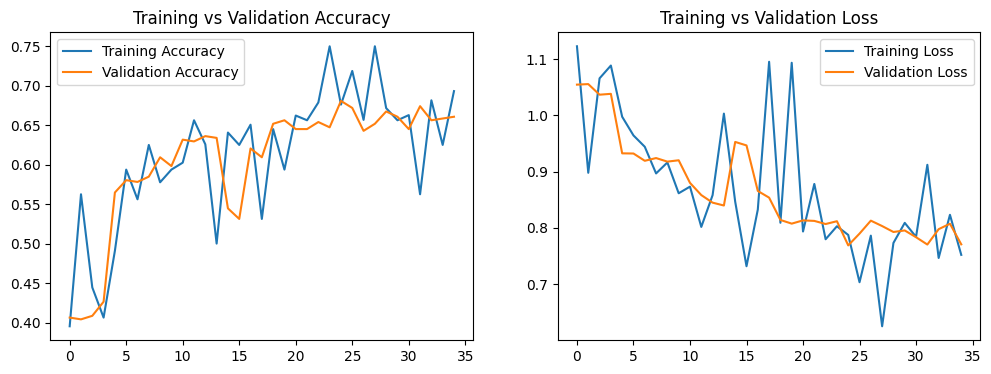

In [ ]:
# Setup Penyimpanan
output_folder = '/content/drive/MyDrive/Machine Learning/Models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

model_filename = 'vit_mini_waste_classifier_3split.keras'
model_path = os.path.join(output_folder, model_filename)

print(f"\nModel akan disimpan ke: {model_path}")

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', # Memantau Validation Generator (Subset 20%)
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("\nMulai Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# **Evaluasi Model**


   EVALUASI PADA DATA TEST (UNSEEN DATA)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 289s 11s/step - accuracy: 0.6126 - loss: 0.9000

Akurasi Final pada Test Set: 59.04%
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step


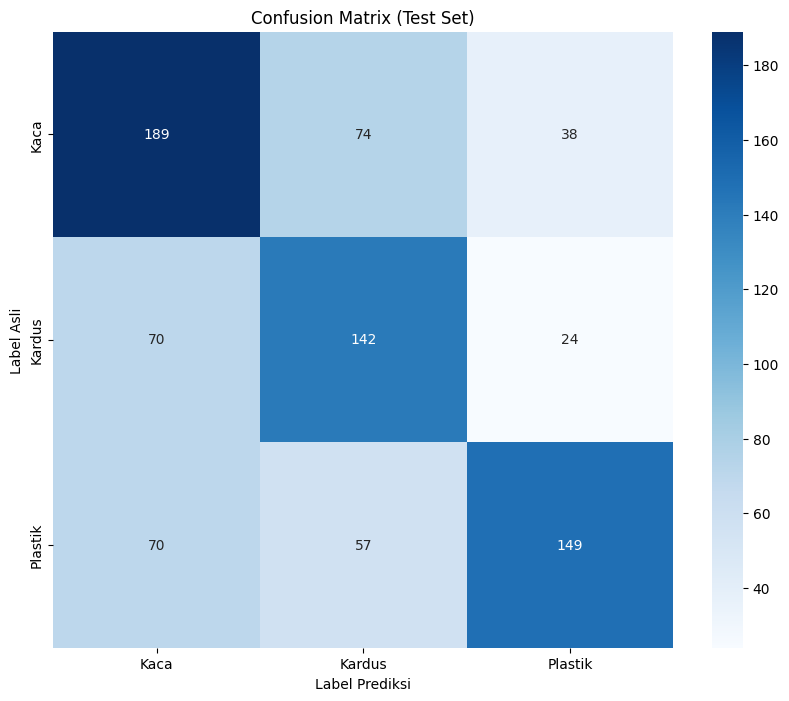


--- Detailed Classification Report (Test Set) ---
              precision    recall  f1-score   support

        Kaca       0.57      0.63      0.60       301
      Kardus       0.52      0.60      0.56       236
     Plastik       0.71      0.54      0.61       276

    accuracy                           0.59       813
   macro avg       0.60      0.59      0.59       813
weighted avg       0.60      0.59      0.59       813



In [ ]:
print("\n" + "="*40)
print("   EVALUASI PADA DATA TEST (UNSEEN DATA)")
print("="*40)

# Load model terbaik (PENTING: Jangan pakai model dari epoch terakhir)
best_model = load_model(model_path, custom_objects={'Patches': Patches, 'PatchEncoder': PatchEncoder})

# Evaluasi Score
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"\nAkurasi Final pada Test Set: {test_accuracy*100:.2f}%")

# Confusion Matrix
test_generator.reset()
Y_pred_prob = best_model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred_prob, axis=1)
Y_true = test_generator.classes

cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_KELAS, yticklabels=LABEL_KELAS)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.show()

# Classification Report
print("\n--- Detailed Classification Report (Test Set) ---")
print(classification_report(Y_true, Y_pred_classes, target_names=LABEL_KELAS))